# Задание
Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - какие зависимости в данных?
    - [сбалансированы](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset) ли классы?
    - основные статистики признаков
- Разделить данные на train/test
    - разделить на обучающую и тестовую подвыборки
    - сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - какие метрики точности?
    - какая модель лучше всего справилась?

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score,precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [2]:
#Загружаем датасет
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#Проверим количество пропущенныз значений
df.isnull().sum().sum()

0

Пропусков нет

In [4]:
#Проверим количество дубликатов
df.duplicated().sum()

1081

Дубликаты есть(

In [5]:
# Удалим дубликаты
df = df.drop_duplicates()

# Какие зависимости в данных?

<Axes: >

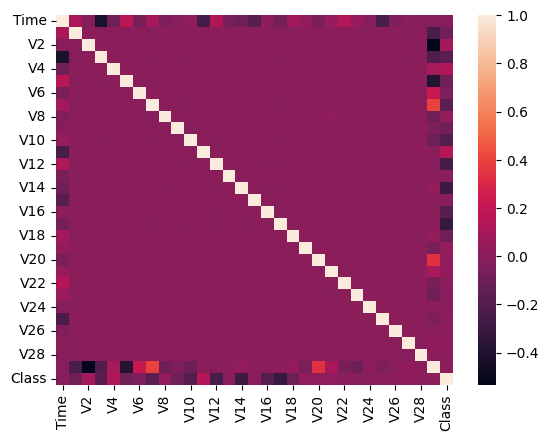

In [6]:
#Для оценки зависимости данных воспользуемся методом датафрейма .corr
df_correlation = df.corr()
sns.heatmap(df_correlation)

**Из полученной матрицы можно сделать вывод, что данные плохо кореллируют между собой.** \
**ненулевые значения можно заметить лишь для зависимости от парметра "Amount" и 'Time'**

# Сбалансированы ли классы?

Как предложено на ресурсе Kaggle, визуализируем данные с помощью pie графика.

Честные транзацкии - 99.83328986416473 %
Мошеннические - 0.1667101358352777 %


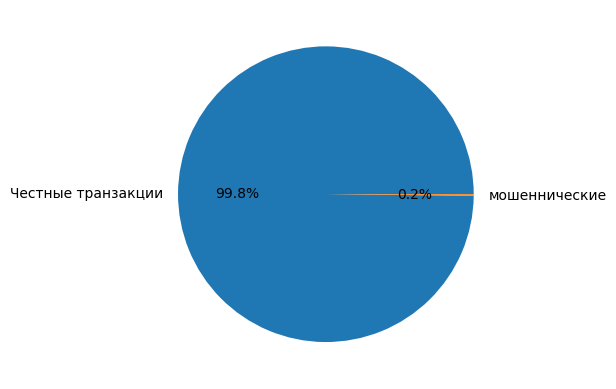

In [7]:
fraud_or_not = df["Class"].value_counts().tolist()
labels = ['Честные транзакции', 'мошеннические']
values = [fraud_or_not[0], fraud_or_not[1]]
print(f"Честные транзацкии - {fraud_or_not[0]/(fraud_or_not[0]+fraud_or_not[1])*100} %")
print(f"Мошеннические - {fraud_or_not[1]/(fraud_or_not[0]+fraud_or_not[1])*100} %")
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.show()

+ **Видно, что данные плохо сбалансированы**
+ **Соотношение составляет 99.8 и 0.17%**

# Основные статистики признаков

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


# Разделить на обучающую и тестовую подвыборки

Разобьем данные на тренировочные train и тестовые test методом из sklearn

In [9]:
X = df.drop(["Class"], axis = 1)
Y = df.Class

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y)

Train
Честные транзацкии - 99.83334004672521 %
Мошеннические - 0.16665995327479255 %
Test
Честные транзацкии - 99.83317277191664 %
Мошеннические - 0.1668272280833666 %


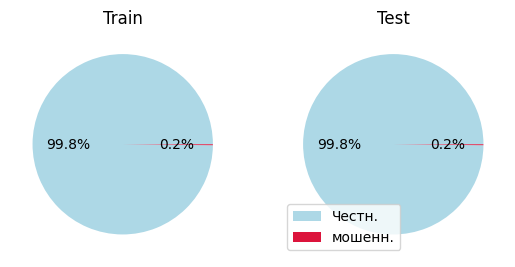

In [11]:
fraud_or_not_train = Y_train.value_counts().tolist()
fraud_or_not_test = Y_test.value_counts().tolist()

labels = ['Честн.', 'мошенн.']
values_train = [fraud_or_not_train[0], fraud_or_not_train[1]]
values_test = [fraud_or_not_test[0], fraud_or_not_test[1]]

print("Train")
print(f"Честные транзацкии - {fraud_or_not_train[0]/(fraud_or_not_train[0]+fraud_or_not_train[1])*100} %")
print(f"Мошеннические - {fraud_or_not_train[1]/(fraud_or_not_train[0]+fraud_or_not_train[1])*100} %")


print("Test")
print(f"Честные транзацкии - {values_test[0]/(values_test[0]+values_test[1])*100} %")
print(f"Мошеннические - {values_test[1]/(values_test[0]+values_test[1])*100} %")

fig,  (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.pie(values_train, autopct='%1.1f%%', colors=["lightblue", 'crimson'])
ax1.set_title('Train')
ax2.set_title('Test')
ax2.pie(values_test, autopct='%1.1f%%', colors=["lightblue", 'crimson'])
plt.legend(labels, loc=3)
plt.show()

**Соотношение классов сохранилось**

In [12]:
X_train.describe() - X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,57.125848,0.005018,0.005751,-0.004177,-0.003135,-0.002355,-0.005351,0.005295,0.000166,-0.003883,...,-0.000042,-0.001907,-0.000404,-0.007409,-0.000892,-0.002041,-0.000007,0.002577,0.000914,0.716546
std,101.247946,-0.028047,-0.035382,0.000712,-0.002575,0.026081,0.001417,0.039799,-0.005326,-0.002680,...,-0.001591,0.000459,0.001573,0.011390,0.003353,-0.002831,-0.001930,-0.006847,-0.007392,12.117195
min,0.000000,-16.364972,-28.076483,-14.644605,-0.266856,-84.927730,-2.663792,-2.050445,-22.273350,0.113912,...,-31.659172,-12.164698,-2.046127,8.141735,0.013943,1.598770,-0.362930,12.670435,-3.719188,0.000000
25%,-224.750000,-0.002940,0.001411,-0.006918,0.004016,0.006607,-0.001430,0.005044,0.002397,0.002475,...,-0.000765,-0.001876,-0.007484,-0.000622,-0.001388,-0.001166,0.001225,-0.000254,0.000641,-0.110000
50%,173.500000,-0.005925,0.001459,-0.008424,-0.000825,-0.000157,-0.005261,0.008681,-0.000313,-0.005874,...,-0.000749,0.000208,0.000327,-0.001042,-0.000256,0.000084,-0.000790,0.000645,0.000105,0.110000
75%,212.500000,0.000407,-0.001315,-0.000507,-0.002981,0.000186,-0.007827,0.002889,0.002574,-0.005439,...,-0.001346,0.000189,0.003769,-0.000790,0.002593,-0.004244,-0.000637,0.001872,0.000171,1.060000
max,4.000000,0.008425,0.590526,-5.156450,3.731676,0.702357,52.111431,89.691828,3.371229,-5.202106,...,13.183513,-4.587950,2.141105,0.444867,0.570105,-1.667105,0.362018,21.732295,11.227736,12780.230000


**Статистики обоих выборок близки**

### Нормализация данных 

In [13]:
ss = StandardScaler()
ss.fit(X_train)

X_train_norm = pd.DataFrame(data=ss.transform(X_train), columns=ss.get_feature_names_out())
X_test_norm = pd.DataFrame(data=ss.transform(X_test), columns=ss.get_feature_names_out())

# Логистическая регрессия

In [14]:
#Обучение
logistic_regression = LogisticRegression(class_weight="balanced")
logistic_regression.fit(X_train_norm, Y_train);

In [15]:
#Предсказание
Y_logistic_regression_pred = logistic_regression.predict(X_test_norm)

In [16]:
print(classification_report(Y_test, Y_logistic_regression_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.06      0.92      0.11       142

    accuracy                           0.98     85118
   macro avg       0.53      0.95      0.55     85118
weighted avg       1.00      0.98      0.99     85118



# RandomForestClassifier

In [17]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train_norm, Y_train);

In [18]:
Y_random_forest_pred = random_forest.predict(X_test_norm)

In [19]:
print(classification_report(Y_test, Y_random_forest_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.82      0.88       142

    accuracy                           1.00     85118
   macro avg       0.98      0.91      0.94     85118
weighted avg       1.00      1.00      1.00     85118



# Сэмплирование

В целом сэмплирование - это корректировка обучающей выборки с целью балансировки распределения классов в наборе данных.
Воспользуемся различными метдами сэмплирования и оценим результаты

# Undersampling
В целом исходя из названия можно понять что будет происходить, а именно уменьшение экземпляров мажоритарного класса

In [20]:
under_sampler = RandomUnderSampler(random_state=42)
X_undersample, Y_undersample = under_sampler.fit_resample(X_train_norm, Y_train)

Честные транзацкии - 50.0 %, 331 экземпляров
Мошеннические - 50.0 %, 331 экземпляров 


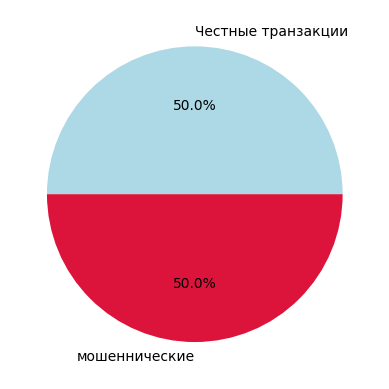

In [21]:
fraud_or_not = Y_undersample.value_counts().tolist()
labels = ['Честные транзакции', 'мошеннические']
values = [fraud_or_not[0], fraud_or_not[1]]
print(f"Честные транзацкии - {fraud_or_not[0]/(fraud_or_not[0]+fraud_or_not[1])*100} %, {fraud_or_not[0]} экземпляров")
print(f"Мошеннические - {fraud_or_not[1]/(fraud_or_not[0]+fraud_or_not[1])*100} %, {fraud_or_not[1]} экземпляров ")
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=["lightblue", 'crimson'])
plt.show()

### Undersampling + Logistic Regression

In [24]:
#Обучение
logistic_regression = LogisticRegression(class_weight="balanced")
logistic_regression.fit(X_undersample, Y_undersample);

In [25]:
#Предсказание
Y_logistic_pred_under = logistic_regression.predict(X_test_norm)

In [26]:
print(classification_report(Y_test, Y_logistic_pred_under))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84976
           1       0.03      0.92      0.07       142

    accuracy                           0.96     85118
   macro avg       0.52      0.94      0.52     85118
weighted avg       1.00      0.96      0.98     85118



In [28]:
#Обучение
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_undersample, Y_undersample);

In [29]:
#Предсказание
Y_forest_pred_under = logistic_regression.predict(X_test_norm)

In [30]:
print(classification_report(Y_test, Y_forest_pred_under))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84976
           1       0.03      0.92      0.07       142

    accuracy                           0.96     85118
   macro avg       0.52      0.94      0.52     85118
weighted avg       1.00      0.96      0.98     85118



# Oversampling
При оверсемплинге напротив экземпляры миноритарноо класса будут множится

In [31]:
over_sampler = RandomOverSampler(random_state=42)
X_oversample, Y_oversample = over_sampler.fit_resample(X_train_norm, Y_train)

Честные транзацкии - 50.0 %, 198277 экземпляров
Мошеннические - 50.0 %, 198277 экземпляров 


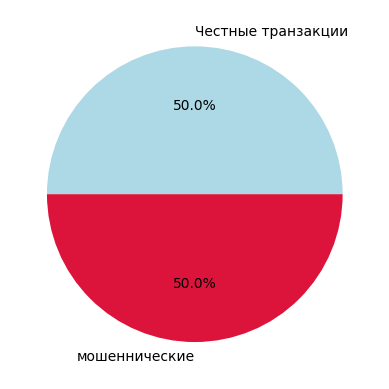

In [32]:
fraud_or_not = Y_oversample.value_counts().tolist()
labels = ['Честные транзакции', 'мошеннические']
values = [fraud_or_not[0], fraud_or_not[1]]
print(f"Честные транзацкии - {fraud_or_not[0]/(fraud_or_not[0]+fraud_or_not[1])*100} %, {fraud_or_not[0]} экземпляров")
print(f"Мошеннические - {fraud_or_not[1]/(fraud_or_not[0]+fraud_or_not[1])*100} %, {fraud_or_not[1]} экземпляров ")
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=["lightblue", 'crimson'])
plt.show()

### Oversampling + Logistic Regression

In [34]:
#Обучение
logistic_regression = LogisticRegression(class_weight="balanced")
logistic_regression.fit(X_oversample, Y_oversample);

In [35]:
#Предсказание
Y_logistic_pred_over = logistic_regression.predict(X_test_norm)

In [36]:
print(classification_report(Y_test, Y_logistic_pred_over))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.06      0.92      0.11       142

    accuracy                           0.98     85118
   macro avg       0.53      0.95      0.55     85118
weighted avg       1.00      0.98      0.99     85118



### Overrsampling + RandomForestClassifier

In [38]:
#Обучение
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_oversample, Y_oversample);

In [39]:
#Предсказание
Y_forest_pred_over = logistic_regression.predict(X_test_norm)

In [40]:
print(classification_report(Y_test, Y_forest_pred_over))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.06      0.92      0.11       142

    accuracy                           0.98     85118
   macro avg       0.53      0.95      0.55     85118
weighted avg       1.00      0.98      0.99     85118



# SMOTE
Это тоже оверсемплинг, но тут новые экземпляры миноритарного класса не дублируются, а создаются новые.

In [41]:
SMOTE_sampler = SMOTE(random_state=42)
X_SMOTE, Y_SMOTE = SMOTE_sampler.fit_resample(X_train_norm, Y_train)

Честные транзацкии - 50.0 %, 198277 экземпляров
Мошеннические - 50.0 %, 198277 экземпляров 


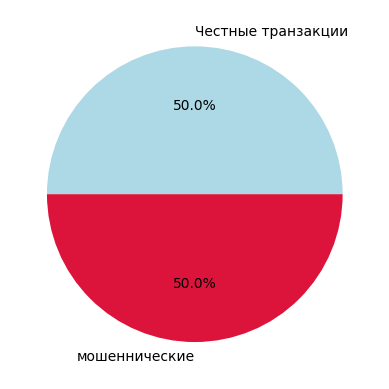

In [42]:
fraud_or_not = Y_SMOTE.value_counts().tolist()
labels = ['Честные транзакции', 'мошеннические']
values = [fraud_or_not[0], fraud_or_not[1]]
print(f"Честные транзацкии - {fraud_or_not[0]/(fraud_or_not[0]+fraud_or_not[1])*100} %, {fraud_or_not[0]} экземпляров")
print(f"Мошеннические - {fraud_or_not[1]/(fraud_or_not[0]+fraud_or_not[1])*100} %, {fraud_or_not[1]} экземпляров ")
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=["lightblue", 'crimson'])
plt.show()

### SMOTE + Logistic Regression

In [44]:
#Обучение
logistic_regression = LogisticRegression(class_weight="balanced")
logistic_regression.fit(X_SMOTE, Y_SMOTE);

In [45]:
#Предсказание
Y_logistic_pred_SMOTE = logistic_regression.predict(X_test_norm)

In [46]:
print(classification_report(Y_test, Y_logistic_pred_SMOTE))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.92      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.94      0.54     85118
weighted avg       1.00      0.97      0.99     85118



### SMOTE + RandomForestClassifier

In [48]:
#Обучение
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_SMOTE, Y_SMOTE);

In [49]:
#Предсказание
Y_forest_pred_SMOTE = logistic_regression.predict(X_test_norm)

In [50]:
print(classification_report(Y_test, Y_forest_pred_SMOTE))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.92      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.94      0.54     85118
weighted avg       1.00      0.97      0.99     85118



# Выводы по моделям
Соберем все результаты и проанализируем

In [53]:

recall_arr = []
precision_arr = []
f1_arr = []
default_regression = classification_report(Y_test, Y_logistic_regression_pred, output_dict=True)
default_forest = classification_report(Y_test, Y_random_forest_pred, output_dict=True)
recall_arr.append(default_regression['1']["recall"])
precision_arr.append(default_regression['1']["precision"])
recall_arr.append(default_forest['1']["recall"])
precision_arr.append(default_forest['1']["precision"])
f1_arr.append(default_regression['1']["f1-score"])
f1_arr.append(default_forest['1']["f1-score"])


under_regression = classification_report(Y_test, Y_logistic_pred_under, output_dict=True)
under_forest = classification_report(Y_test, Y_forest_pred_under, output_dict=True)
recall_arr.append(under_regression['1']["recall"])
precision_arr.append(under_regression['1']["precision"])
recall_arr.append(under_forest['1']["recall"])
precision_arr.append(under_forest['1']["precision"])
f1_arr.append(under_regression['1']["f1-score"])
f1_arr.append(under_forest['1']["f1-score"])


over_regression = classification_report(Y_test, Y_logistic_pred_over, output_dict=True)
over_forest = classification_report(Y_test, Y_forest_pred_over, output_dict=True)
recall_arr.append(over_regression['1']["recall"])
precision_arr.append(over_regression['1']["precision"])
recall_arr.append(over_forest['1']["recall"])
precision_arr.append(over_forest['1']["precision"])
f1_arr.append(over_regression['1']["f1-score"])
f1_arr.append(over_forest['1']["f1-score"])

SMOTE_regression = classification_report(Y_test, Y_logistic_pred_SMOTE, output_dict=True)
SMOTE_forest = classification_report(Y_test, Y_forest_pred_SMOTE, output_dict=True)
recall_arr.append(SMOTE_regression['1']["recall"])
precision_arr.append(SMOTE_regression['1']["precision"])
recall_arr.append(SMOTE_forest['1']["recall"])
precision_arr.append(SMOTE_forest['1']["precision"])
f1_arr.append(SMOTE_regression['1']["f1-score"])
f1_arr.append(SMOTE_forest['1']["f1-score"])


names = ["Regression", "RForest", "Unders. + Regression", "Unders. + RForest", "Over. + Regression", "Over. + RForest", "SMOTE + Regression", "SMOTE + RForest" ]


C:\Users\tishkov.m\AppData\Local\Temp\ipykernel_11708\4017679563.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(names,rotation=90)
C:\Users\tishkov.m\AppData\Local\Temp\ipykernel_11708\4017679563.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(names,rotation=90)
C:\Users\tishkov.m\AppData\Local\Temp\ipykernel_11708\4017679563.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(names,rotation=90)


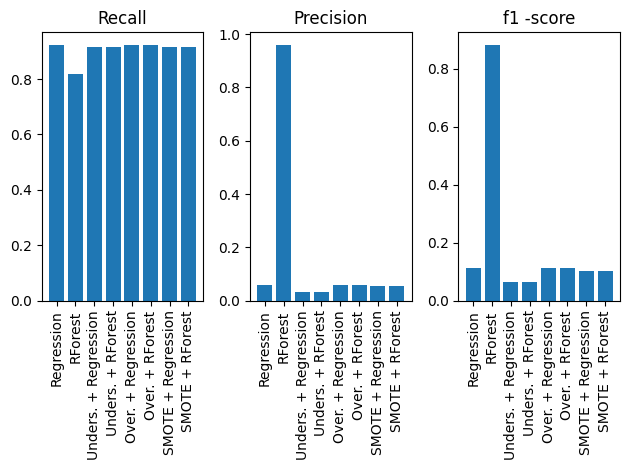

Regression : Recall = 0.9225352112676056; Precision = 0.059626763768775605; f1-score = 0.11201368106028217 
RForest : Recall = 0.8169014084507042; Precision = 0.9586776859504132; f1-score = 0.8821292775665399 
Unders. + Regression : Recall = 0.9154929577464789; Precision = 0.03411178168459722; f1-score = 0.06577283076144701 
Unders. + RForest : Recall = 0.9154929577464789; Precision = 0.03411178168459722; f1-score = 0.06577283076144701 
Over. + Regression : Recall = 0.9225352112676056; Precision = 0.0595184007269423; f1-score = 0.11182244985061887 
Over. + RForest : Recall = 0.9225352112676056; Precision = 0.0595184007269423; f1-score = 0.11182244985061887 
SMOTE + Regression : Recall = 0.9154929577464789; Precision = 0.0546218487394958; f1-score = 0.10309278350515463 
SMOTE + RForest : Recall = 0.9154929577464789; Precision = 0.0546218487394958; f1-score = 0.10309278350515463 


In [54]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3)
ax1.bar(names,recall_arr)
ax1.set_xticklabels(names,rotation=90)
ax1.set_title("Recall")

ax2.bar(names,precision_arr)
ax2.set_xticklabels(names,rotation=90)
ax2.set_title("Precision")

ax3.bar(names,f1_arr)
ax3.set_xticklabels(names,rotation=90)
ax3.set_title("f1 -score")
fig.tight_layout()
plt.show()

for i in range(len(names)):
    print(f"{names[i]} : Recall = {recall_arr[i]}; Precision = {precision_arr[i]}; f1-score = {f1_arr[i]} ")

# Выводы
По результатам работы можно сделать вывод, что линейная регрессия очень плохо справляется с этой задачей (что логично, в силу высокой нелинейности), при сэмплировании recall, precision, f1-score для линейной регрессии меняются незначительно.

При использовании метода RandomForestClassifier удалось добиться хороших результатов на исходном датасете. При использовании семплирований результаты сильно ухудшились.

**Вывод Из рассмотренных моделей лучше всего себя показала модель RandomForestClassifier на данных без сэмплирования**